## DFIM Importance Score Comparison

This notebook compares the performance of DFIM on different types of importance scores for the same analysis, given the same model. DFIM will only work as well as the model 

In [1]:
# Imports

import os, sys
import numpy as np
import pandas as pd
import gzip

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt

import pickle
import itertools
from statsmodels.sandbox.stats.multicomp import multipletests

from keras.models import model_from_json
from Bio import SeqIO

import dfim
import dfim.util
import dfim.core
import dfim.null_model


Using Theano backend.
Using gpu device 5: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)


In [2]:
# Specify data files

labels_file = '../data/embedded_motif_interaction_data/labels.txt.gz'
fasta_file = '../data/embedded_motif_interaction_data/sequences.fa.gz'
simdata_file = '../data/embedded_motif_interaction_data/simulation_metadata.txt.gz'

model_weights = '../data/embedded_motif_interaction_data/model_weights.h5'
model_architecture = '../data/embedded_motif_interaction_data/model_architecture.json'


In [3]:
# Load sequences

fasta_sequences = SeqIO.parse(gzip.open(fasta_file),'fasta')

sequence_list = []
seq_fasta_list = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    seq_fasta_list.append(sequence)
    new_sequence = dfim.util.one_hot_encode(sequence)
    sequence_list.append(new_sequence)
    
sequences = np.array(sequence_list)


In [4]:
# Load model 

model_json = open(model_architecture, 'r').read()
model = model_from_json(model_json)
model.load_weights(model_weights)

In [5]:
# Get all correctly predicted positive sequences

all_labels = pd.read_table(labels_file)
all_predictions = model.predict(sequences)

true_labels = all_labels.iloc[:, 3].tolist()
predicted_labels = all_predictions[:, 0].tolist()

correct_pred_list = dfim.util.get_correct_predictions(true_labels, predicted_labels)


In [6]:
# Subset to 1,000 Class 3 sequences to speed the example

compute_range = range(50000, 51000)
compute_index = [el for el in compute_range if el in correct_pred_list]


In [7]:
# Recover known locations of motifs

mutant_loc_dict = dfim.util.process_locations_from_simdata(sequences, simdata_file)


In [8]:
# Specify importance score types to iterate over

importance_types = { 'grad_input_ref_0':
                        {'score_type': 'gradient_input',
                         'reference_gc': 0,
                         'reference_shuffle_type': None },
                    'deeplift_dinuc':
                        {'score_type': 'deeplift',
                         'reference_gc': None,
                         'reference_shuffle_type': 'dinuc' },
                    'deeplift_random':
                        {'score_type': 'deeplift',
                         'reference_gc': None,
                         'reference_shuffle_type': 'random' },
                    'deeplift_gc':
                        {'score_type': 'deeplift',
                         'reference_gc': 0.46,
                         'reference_shuffle_type': None },
}

In [9]:
mutated_seq_array_dict = {}
mutated_seq_key_dict = {}
mutated_seq_preds_dict = {}
score_dict = {}
delta_dict = {}
dfim_dict = {}
shuf_score_dict = {}
shuf_delta_dict = {}
shuf_dfim_dict = {}

for i_type in importance_types.keys():

    # Generate mutated sequences and a key that specifies the index of each 
    # of the sequence and which mutation is present there
    (mutated_seq_array, mutated_seq_key) = \
                dfim.core.generate_mutants_and_key(sequences, 
                                                   mut_loc_dict=mutant_loc_dict,
                                                   sequence_index=compute_index,
                                                   mutant_gc_fraction=0)

    # Look at how these mutations change the model's predictions
    mutated_seq_preds = model.predict(mutated_seq_array)

    
    mutated_seq_array_dict[i_type] = mutated_seq_array
    mutated_seq_key_dict[i_type] = mutated_seq_key
    mutated_seq_preds_dict[i_type] = mutated_seq_preds

    # Compute importance scores for original and mutated sequences
    score_dict[i_type] = dfim.core.compute_importance(model, mutated_seq_array, 
                                  tasks=[0],
                                  score_type=importance_types[i_type]['score_type'],
                                  find_scores_layer_idx=0,
                                  target_layer_idx=-2,
                                  reference_gc=importance_types[i_type]['reference_gc'],
                                  reference_shuffle_type=importance_types[i_type]['reference_shuffle_type'])

    # Compute the change in importance scores as a result of each mutation
    tasks = [0]
    delta_dict[i_type] = dfim.core.compute_delta_profiles(score_dict[i_type], mutated_seq_key, 
                                                  mutant_loc_dict, tasks, 
                                                  compute_index, 
                                                  mutated_seq_preds)


    # Compute DFIM by taking the maximal total affect across all 4 bases for each position
    dfim_dict[i_type] = dfim.core.compute_dfim(delta_dict[i_type], compute_index, tasks,
                                               operations=[np.sum, np.max], 
                                               operation_axes=[1, 0],
                                               absolute_value=True, annotate=True, 
                                               mutated_seq_key=mutated_seq_key)


    
    # Shuffle sequences
    shuf_sequences = dfim.null_model.shuffle_seq_from_one_hot(sequences, dinuc=False)


    # Repeat DFIM procedure
    (shuf_mutated_seq_array, shuf_mutated_seq_key) = \
                dfim.core.generate_mutants_and_key(shuf_sequences, 
                                                   mut_loc_dict=mutant_loc_dict,
                                                   sequence_index=compute_index,
                                                   mutant_gc_fraction=0)

    shuf_mutated_seq_preds = model.predict(shuf_mutated_seq_array)

    shuf_score_dict[i_type] = dfim.core.compute_importance(model, shuf_mutated_seq_array, 
                                                   tasks=[0],
                                                   score_type=importance_types[i_type]['score_type'],
                                                   find_scores_layer_idx=0,
                                                   target_layer_idx=-2,
                                                   reference_gc=importance_types[i_type]['reference_gc'],
                                                   reference_shuffle_type=importance_types[i_type]['reference_shuffle_type'])

    shuf_delta_dict[i_type] = dfim.core.compute_delta_profiles(shuf_score_dict[i_type], 
                                                               shuf_mutated_seq_key, 
                                                               mutant_loc_dict, tasks, compute_index, 
                                                               shuf_mutated_seq_preds)


    shuf_dfim_dict[i_type] = dfim.core.compute_dfim(shuf_delta_dict[i_type], 
                                                    compute_index, tasks,
                                                    operations=[np.sum, np.max], 
                                                    operation_axes=[1, 0],
                                                    absolute_value=True, annotate=True, 
                                                    mutated_seq_key=shuf_mutated_seq_key)


    
    
    

Generating mutated sequences
Calculating Importance Scores
nonlinear_mxts_mode is set to: Gradient
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Done 0
Done 1000
Done 2000
Done 3000
Using random shuffle
Generating mutated sequences
Calculating Importance Scores
nonlinear_mxts_mode is set to: Gradient
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Done 0
Done 1000
Done 2000
Done 3000
Generating mutated sequences
Calculating Importance Scores
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 3 the preceding linear layer is preact_3 of type Dense;
In accor

In [14]:
all_motifs = ['TAL1', 'ELF1', 'SIX5', 'AP1']

interact_score_dict = {}

for i_type in importance_types.keys():

    interact_score_dict[i_type] = {'_'.join(sorted([m1, m2])): [] 
                                   for (m1, m2) 
                                   in itertools.combinations(all_motifs, 2)} 

    for task in dfim_dict[i_type].keys():
        for seq in dfim_dict[i_type][task].keys():
            for i in dfim_dict[i_type][task][seq].index:

                row_motif = i.split('_')[1]

                for c in dfim_dict[i_type][task][seq].columns:
                    col_motif = c.split('_')[1]

                    if i == c:
                        continue
                    else:
                        interact_score_dict[i_type]['_'.join(sorted([row_motif, col_motif]))].append(
                                                     dfim_dict[i_type][task][seq].loc[i, c])


grad_input_ref_0
deeplift_random
deeplift_gc
deeplift_dinuc


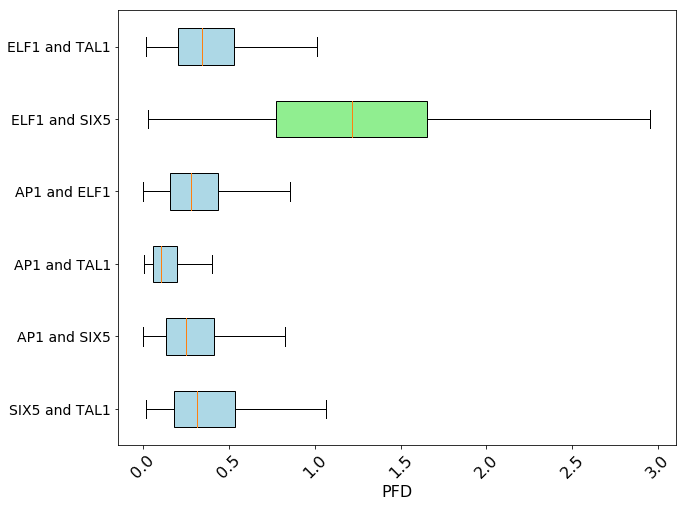

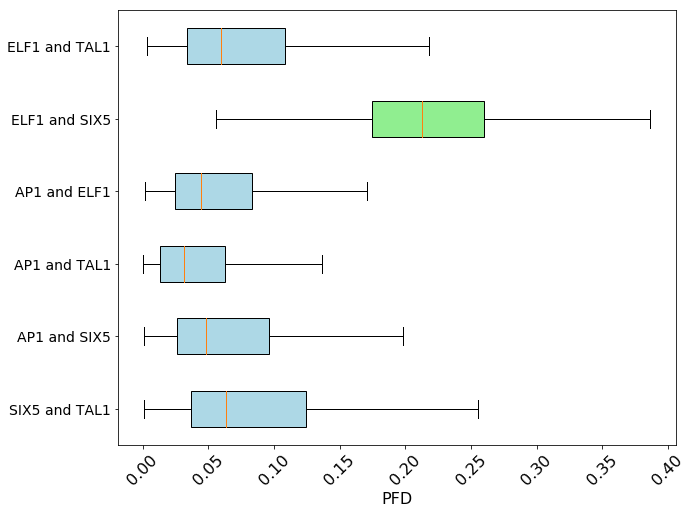

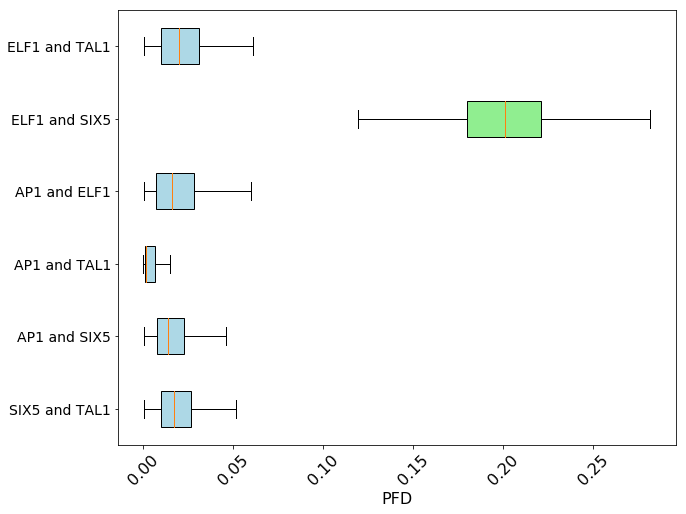

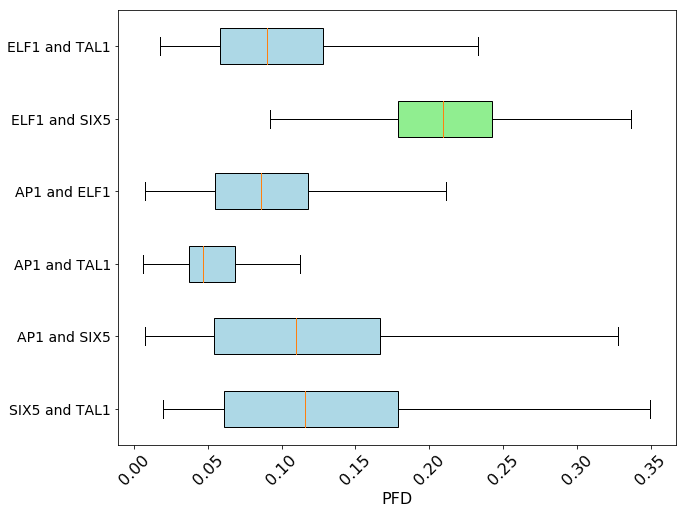

In [18]:
%matplotlib inline  


for i_type in importance_types.keys():
    
    print i_type

    all_data = [interact_score_dict[i_type][perm] 
                for perm in interact_score_dict[i_type].keys()]
    labels = interact_score_dict[i_type].keys()
    tick_labels = [' and '.join([l.split('_')[0], 
                                 l.split('_')[1]]) 
                           for l in labels]

    plt.figure(figsize=(10,8))
    bplot1 = plt.boxplot(all_data, patch_artist=True,
                         labels=tick_labels, 
                         showfliers=False,
                         widths=0.5,
                         vert=False)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=45, fontsize=16)
    plt.xlabel('PFD', fontsize=16)
    colors = ['lightblue'] * len(tick_labels)
    colors[-2] = 'lightgreen'
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
#     plt.show()
    plt.savefig('/mnt/lab_data/kundaje/users/pgreens/projects/DFIM/figures/embedding_interaction_scores_%s.png'%i_type, 
                        format='png', bbox_inches='tight')
    plt.savefig('/mnt/lab_data/kundaje/users/pgreens/projects/DFIM/figures/embedding_interaction_scores_%s.pdf'%i_type,
                        format='pdf', bbox_inches='tight')

In [19]:
### Compute Pvalues 

reload(dfim.null_model)

all_motifs = ['TAL1', 'ELF1', 'SIX5', 'AP1']

dfim_pval_dict = {}
interact_score_dict = {}

for i_type in importance_types.keys():

    dfim_pval_dict[i_type] = dfim.null_model.assign_pval(dfim_dict[i_type], 
                                                         shuf_dfim_dict[i_type],
                                                         null_level = 'per_task',
                                                         null_type = 'fit')


    interact_score_dict[i_type] = {'_'.join(sorted([m1, m2])): [] 
                                   for (m1, m2) 
                                   in itertools.combinations(all_motifs, 2)} 

    for task in dfim_pval_dict[i_type].keys():
        for seq in dfim_pval_dict[i_type][task].keys():
            for i in dfim_pval_dict[i_type][task][seq].index:

                row_motif = i.split('_')[1]

                for c in dfim_pval_dict[i_type][task][seq].columns:
                    col_motif = c.split('_')[1]

                    if i == c:
                        continue
                    else:
                        interact_score_dict[i_type]['_'.join(sorted([row_motif, col_motif]))].append(
                                                     dfim_pval_dict[i_type][task][seq].loc[i, c])


grad_input_ref_0
deeplift_random
deeplift_gc
deeplift_dinuc


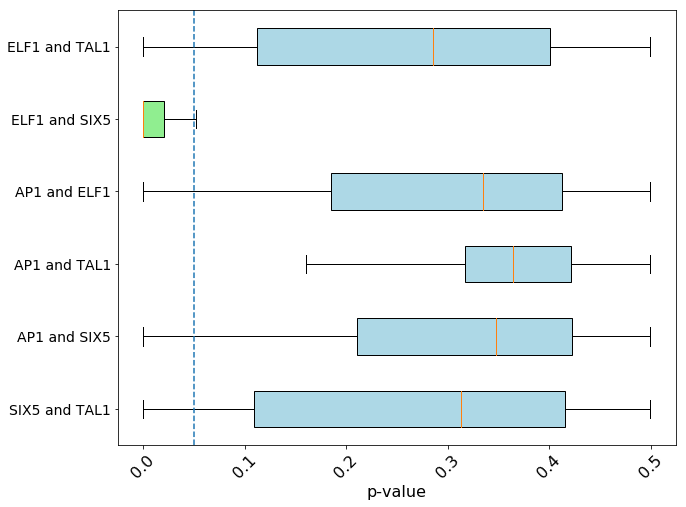

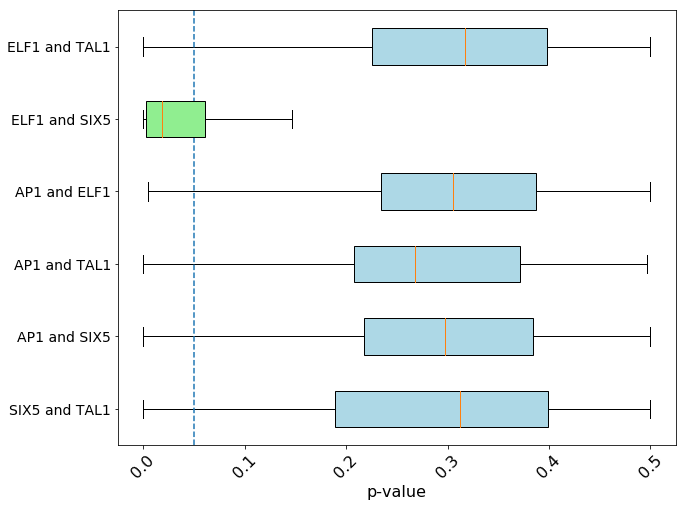

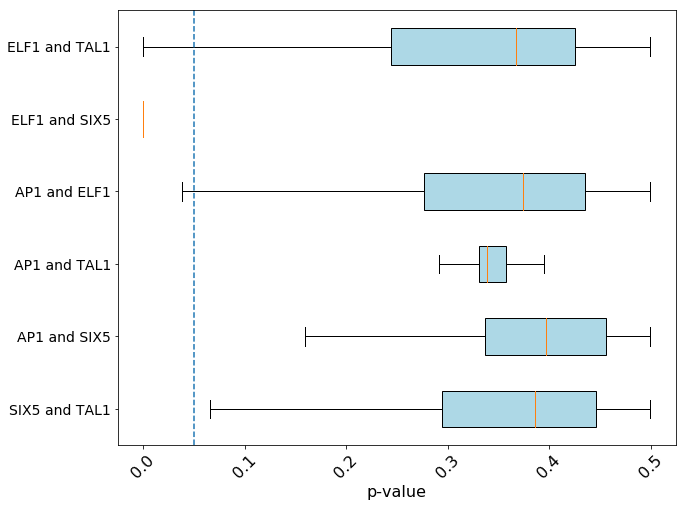

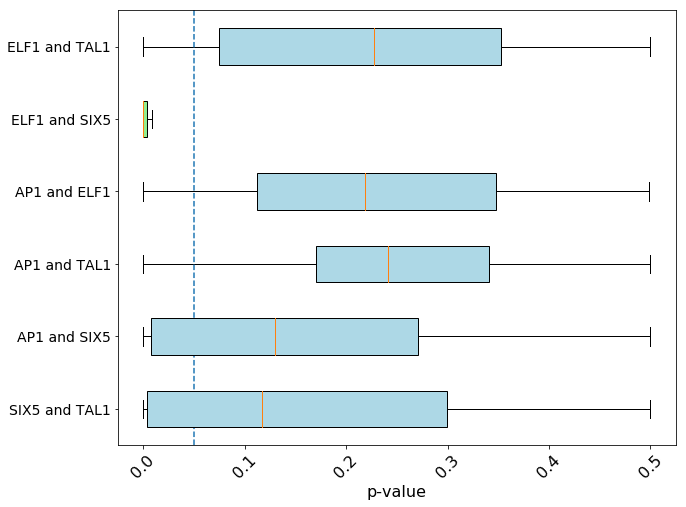

In [20]:
%matplotlib inline  

for i_type in importance_types.keys():
    
    print i_type

    all_data = [interact_score_dict[i_type][perm] 
                    for perm in interact_score_dict[i_type].keys()]
    labels = interact_score_dict[i_type].keys()
    tick_labels = [' and '.join([l.split('_')[0], 
                                 l.split('_')[1]]) 
                           for l in labels]

    plt.figure(figsize=(10,8))
    bplot1 = plt.boxplot(all_data, patch_artist=True,
                         labels=tick_labels, 
                         showfliers=False,
                         widths=0.5,
                         vert=False)
    plt.tick_params(labelsize=14)
    plt.axvline(0.05, ls='dashed')
    plt.xticks(rotation=45, fontsize=16)
    plt.xlabel('p-value', fontsize=16)
    colors = ['lightblue'] * len(tick_labels)
    colors[-2] = 'lightgreen'
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
#     plt.show()
    plt.savefig('/mnt/lab_data/kundaje/users/pgreens/projects/DFIM/figures/embedding_pvalues_%s.png'%i_type, 
                        format='png', bbox_inches='tight')
    plt.savefig('/mnt/lab_data/kundaje/users/pgreens/projects/DFIM/figures/embedding_pvalues_%s.pdf'%i_type,
                        format='pdf', bbox_inches='tight')

grad_input_ref_0
deeplift_random
deeplift_gc
deeplift_dinuc


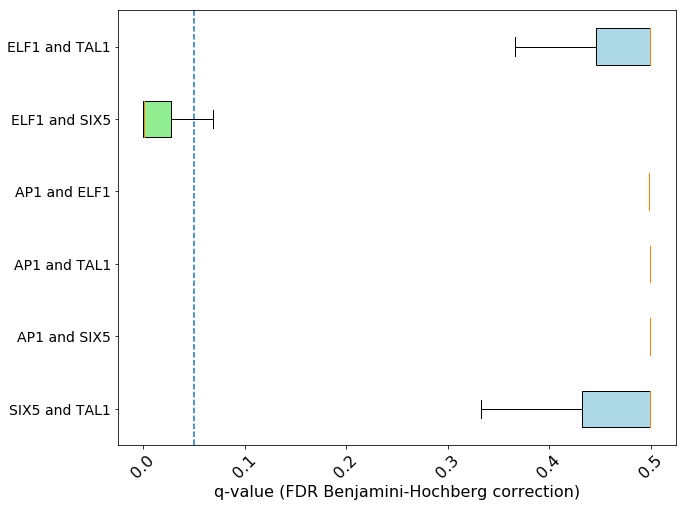

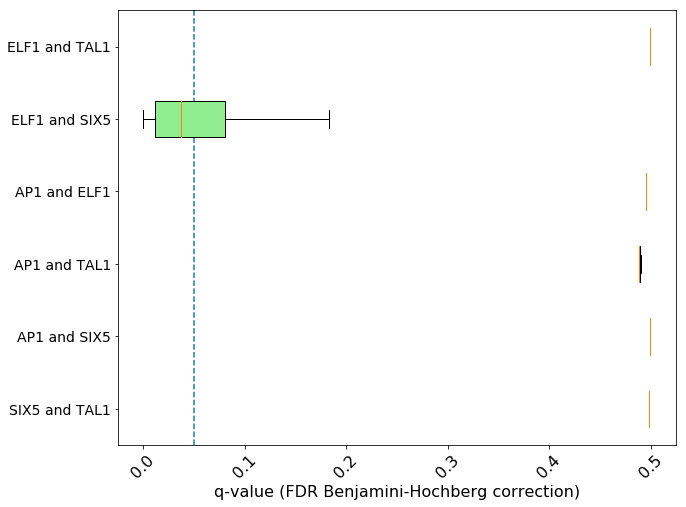

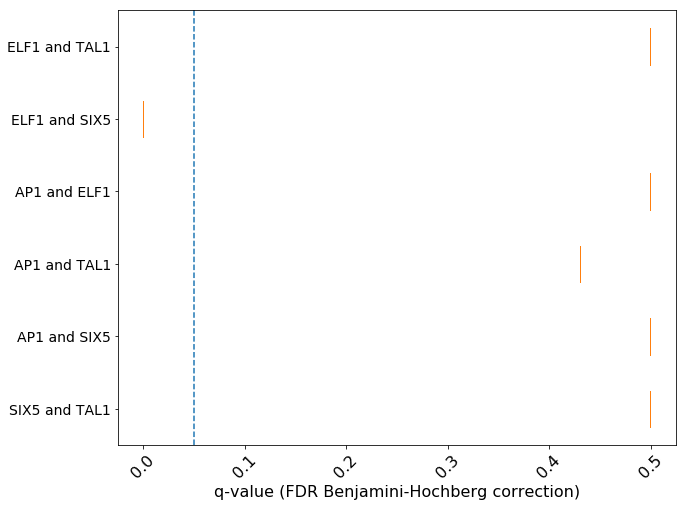

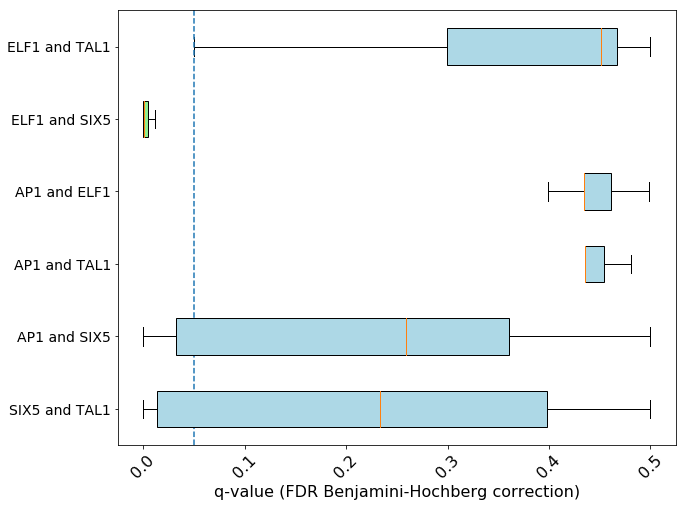

In [28]:
%matplotlib inline  

for i_type in importance_types.keys():
    
    print i_type

    # The second element from multipletests is the array of corrected pvalues
    corrected_data = [multipletests(interact_score_dict[i_type][perm], 
                                    method='fdr_bh')[1]
                        for perm in interact_score_dict[i_type].keys()]

    labels = interact_score_dict[i_type].keys()
    tick_labels = [' and '.join([l.split('_')[0], 
                                 l.split('_')[1]]) 
                           for l in labels]

    plt.figure(figsize=(10,8))
    bplot1 = plt.boxplot(corrected_data, patch_artist=True,
                         labels=tick_labels, 
                         showfliers=False,
                         widths=0.5,
                         vert=False)
    plt.tick_params(labelsize=14)
    plt.axvline(0.05, ls='dashed')
    plt.xticks(rotation=45, fontsize=16)
    plt.xlabel('q-value (FDR Benjamini-Hochberg correction)', fontsize=16)
    colors = ['lightblue'] * len(tick_labels)
    colors[-2] = 'lightgreen'
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
#     plt.show()
    plt.savefig('/mnt/lab_data/kundaje/users/pgreens/projects/DFIM/figures/embedding_qvalues_%s.png'%i_type, 
                        format='png', bbox_inches='tight')
    plt.savefig('/mnt/lab_data/kundaje/users/pgreens/projects/DFIM/figures/embedding_qvalues_%s.pdf'%i_type,
                        format='pdf', bbox_inches='tight')